# Assignment-3 RNN (LSTM-Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

In [4]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<AxesSubplot:xlabel='DATE'>

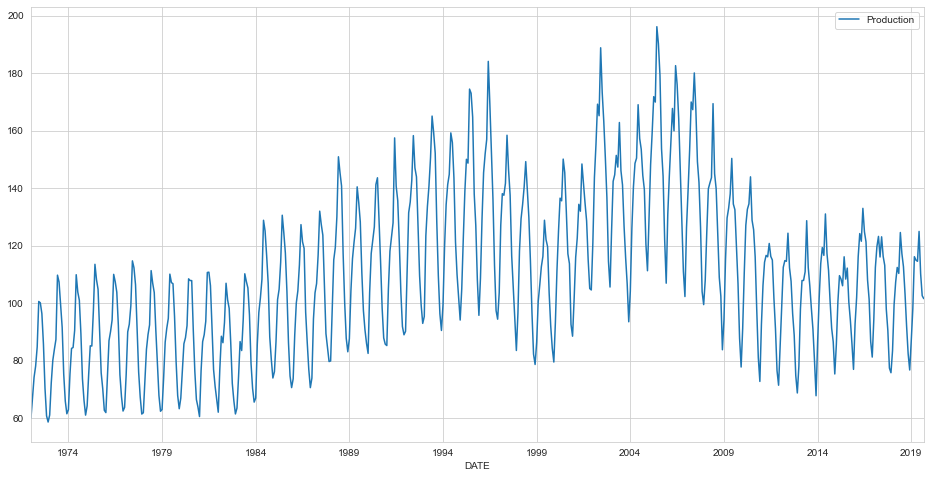

In [7]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# help(TimeseriesGenerator)

In [16]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [17]:
X, y = generator[0]

In [18]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
n_features = 1

### with "tanh" activation function

In [21]:
model1 = Sequential()
model1.add(LSTM(150, activation = 'tanh', input_shape = (length, n_features)))
model1.add(Dense(1))
model1.compile(optimizer = 'adam', loss = 'mse')

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)

In [24]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [25]:
model1.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 5s 6ms/step - loss: 0.0190 - val_loss: 0.0012
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 3/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 4/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0037 - val_loss: 0.0023


<AxesSubplot:>

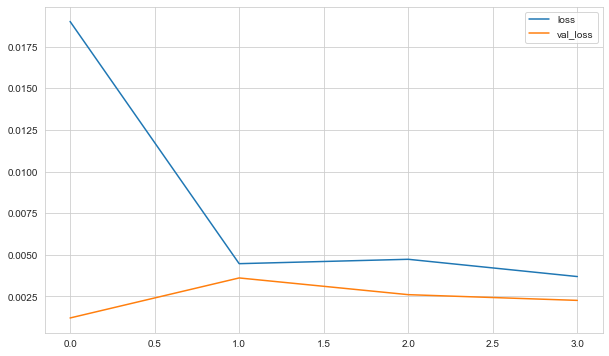

In [26]:
loss_df = pd.DataFrame(model1.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [27]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model1.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['Predictions'] = true_predictions

In [30]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,118.201
2018-05-01,110.354,123.540
2018-06-01,124.584,125.178
2018-07-01,117.222,121.314
2018-08-01,112.678,112.920
2018-09-01,103.312,101.384
2018-10-01,92.132,91.472
2018-11-01,82.435,86.419
2018-12-01,76.761,88.694


<AxesSubplot:xlabel='DATE'>

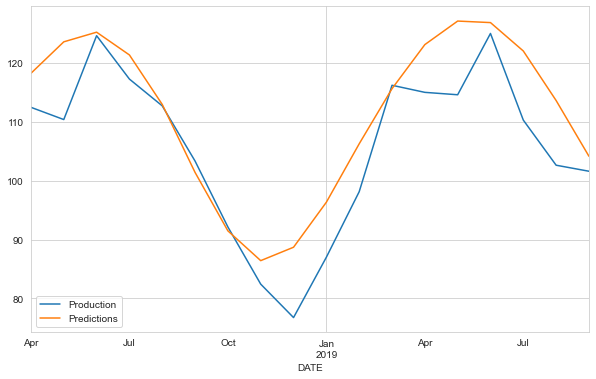

In [31]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [33]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [34]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.6853724740937026 
mae: 6.006329820549485 
mse: 57.21414844878807 
rmse: 7.564003467000004


### with "relu" activation function

In [35]:
model2 = Sequential()
model2.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [36]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [37]:
model2.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
543/543 [==============================] - 4s 5ms/step - loss: 0.0272 - val_loss: 0.0166
Epoch 2/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0093 - val_loss: 0.0018
Epoch 3/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 4/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 5/20
543/543 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 6/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 7/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 9/20
543/543 [==============================] - 2s 5ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 10/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0036 - val_loss: 0.0024

<AxesSubplot:>

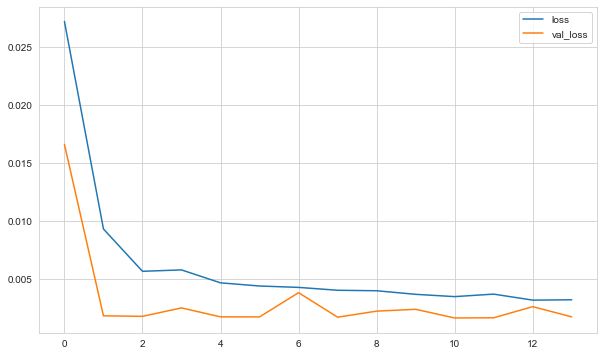

In [38]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [39]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model2.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

#### Inverse Transformations and Comparing

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
test['Predictions'] = true_predictions

In [42]:
test

,Production,Predictions
DATE,,
2018-04-01,112.431,116.081
2018-05-01,110.354,120.272
2018-06-01,124.584,121.402
2018-07-01,117.222,117.200
2018-08-01,112.678,108.419
2018-09-01,103.312,96.527
2018-10-01,92.132,84.224
2018-11-01,82.435,73.815
2018-12-01,76.761,73.149


<AxesSubplot:xlabel='DATE'>

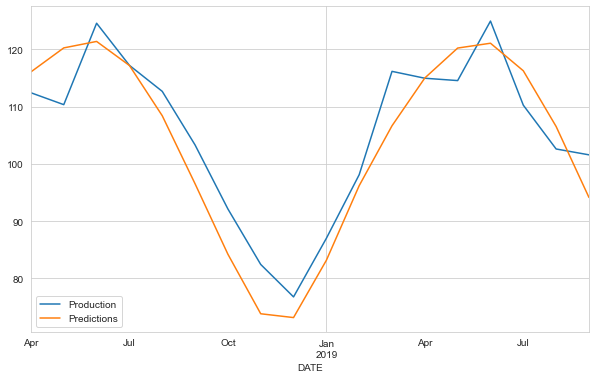

In [43]:
test.plot()

#### Calculation R2 Score and Error Metrics

In [44]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [45]:
eval_metrics(test['Production'], test['Predictions'])

r2_score: 0.8170242990725687 
mae: 5.0112386143261825 
mse: 33.27362691877422 
rmse: 5.768329647200671


## Retrain and Forecasting

In [46]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [47]:
length = 18 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [48]:
model = Sequential()
model.add(LSTM(150, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
555/555 [==============================] - 5s 7ms/step - loss: 0.0279
Epoch 2/8
555/555 [==============================] - 4s 7ms/step - loss: 0.0096
Epoch 3/8
555/555 [==============================] - 4s 7ms/step - loss: 0.0040
Epoch 4/8
555/555 [==============================] - 4s 6ms/step - loss: 0.0031
Epoch 5/8
555/555 [==============================] - 4s 7ms/step - loss: 0.0034
Epoch 6/8
555/555 [==============================] - 4s 6ms/step - loss: 0.0029
Epoch 7/8
555/555 [==============================] - 4s 7ms/step - loss: 0.0029
Epoch 8/8
555/555 [==============================] - 3s 6ms/step - loss: 0.0026


In [49]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [50]:
forecast = scaler.inverse_transform(forecast)

In [51]:
forecast

array([[ 85.06542795],
       [ 76.47671066],
       [ 76.28166548],
       [ 90.16633946],
       [103.84326374],
       [113.94808976],
       [122.25983613],
       [127.59921156],
       [127.05679395],
       [120.28202041],
       [107.95077572],
       [ 93.98387273]])

In [52]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [53]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [54]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [55]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [56]:
forecast_df

,Forecast
2019-10-01,85.065
2019-11-01,76.477
2019-12-01,76.282
2020-01-01,90.166
2020-02-01,103.843
2020-03-01,113.948
2020-04-01,122.260
2020-05-01,127.599
2020-06-01,127.057
2020-07-01,120.282


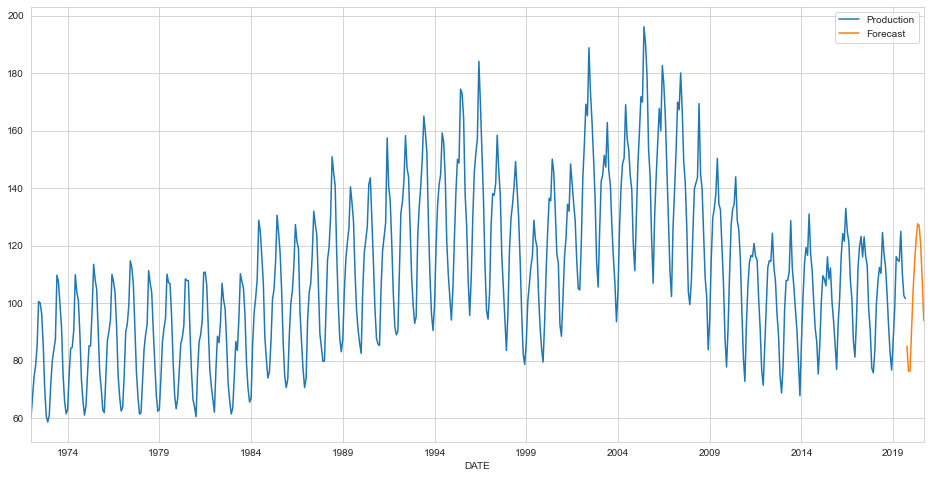

In [57]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 608.0)

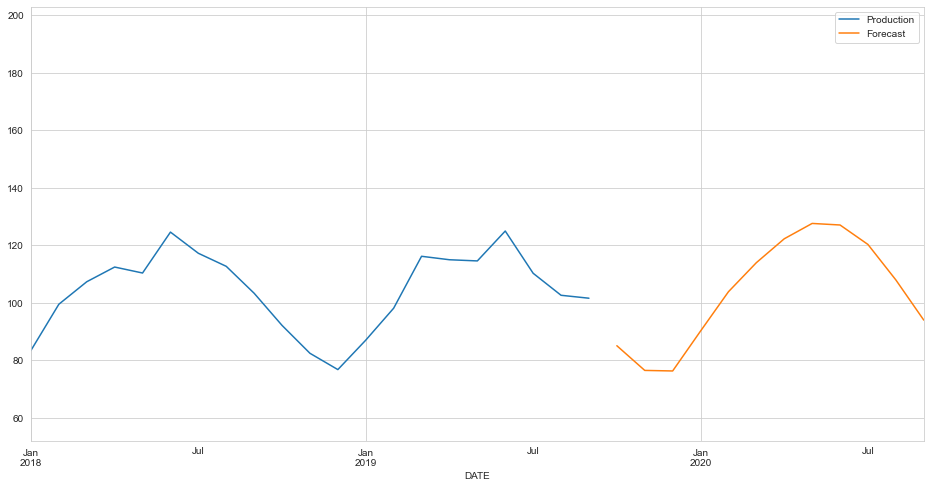

In [58]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-09-01')